In [73]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft
from scipy.signal import find_peaks
from scipy.interpolate import interp1d

Za demonstraciju EMD algoritma koristicemo bijeli sum koji ima istu gustinu energije u svakom frekvencijskom opsegu.

In [74]:
# Generisanje signala x trajanja tr sekundi
tr = 5      # Trajanje signala u sekundama
fs = 100    # Frekvencija odmjeravanja signala u Hz
N  = tr*fs  # Broj odmjeraka(uzoraka) signala

x     = np.random.randn(N)
tAxis = np.linspace(0,tr,N) # vremenska osa [sec]

In [75]:
# Racunanje Discrete Fast Fourier Transform signala x
n_fft = 1024 # Duzina fft-a

xfft  = np.abs(fft(x,n_fft)) # Racunanje FFT-a i uzimanje magnitude
xfft  = xfft[:n_fft//2]      # Uzimamo samo pozitivne frekvencije 
fAxis = np.linspace(0, fs/2, n_fft//2) # frekvencijska osa [Hz]

Text(0.5, 0, 'Frekvencija [Hz]')

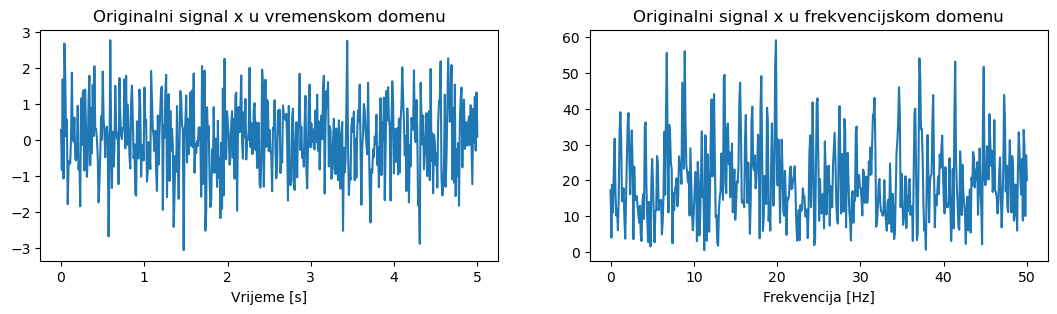

In [76]:
plt.figure(figsize = (13,3))

plt.subplot(1,2,1)
plt.plot(tAxis,x)
plt.xlabel('Vrijeme [s]')
plt.title('Originalni signal x u vremenskom domenu')

plt.subplot(1,2,2)
plt.plot(fAxis,xfft)
plt.title('Originalni signal x u frekvencijskom domenu')
plt.xlabel('Frekvencija [Hz]')

# EMD algoritam

# Prva iteracija (IMF1)

### #1 Pronalazenje lokalnih ekstrema ulaznog signala $ x$ 
Pronaci sve lokalne ekstreme (minimume i maksimume) ulaznog signala $ x$.  
Koristimo funkciju **scipy.signal.find_peaks**.  
Posto funkcija pronalazi samo lokalne maksimume, da bismo uz pomoc nje mogli identifikovati i lokalne minimume moramo invertovati signal.

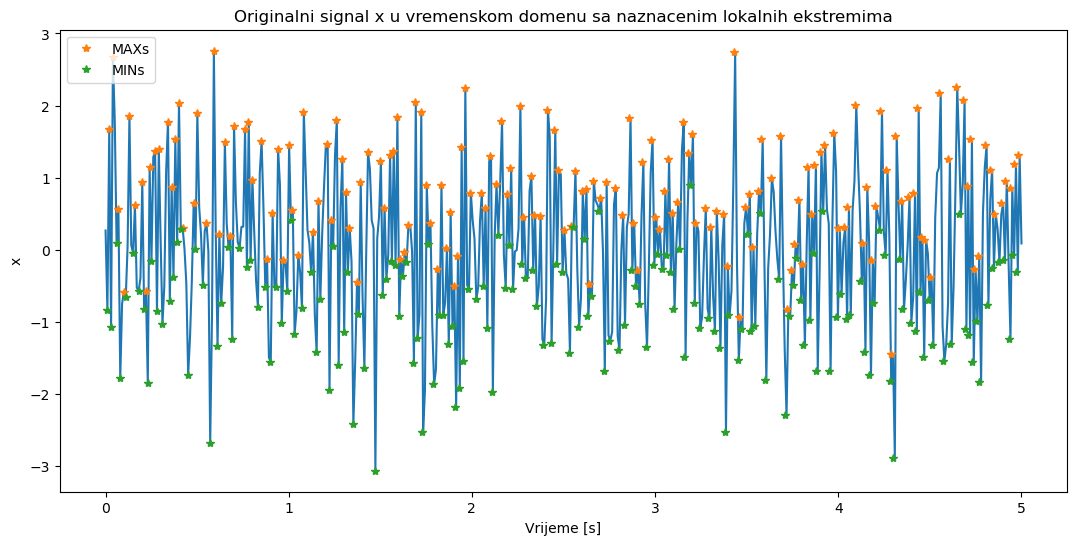

In [77]:
upper_peaks, _ = find_peaks(x)
lower_peaks, _ = find_peaks(-x)

plt.figure(figsize = (13,6))
plt.plot(tAxis,x)
plt.plot(upper_peaks/fs,x[upper_peaks],'*',label = 'MAXs')
plt.plot(lower_peaks/fs,x[lower_peaks],'*',label = 'MINs')
plt.title('Originalni signal x u vremenskom domenu sa naznacenim lokalnih ekstremima')
plt.xlabel('Vrijeme [s]')
plt.ylabel('x')
plt.legend(loc = 'upper left')

## #2 Interpolacija s ciljem dobijanja srednjeg omotaca
Interpoliramo lokalne maksimume kako bismo dobili gornji omotac $ upper envelope $   
Interpoliramo lokalne minimume  kako bismo dobili donji  omotac $ lower envelope $  
Racunamo srednji omotac kao:

> $average\ envelope$ = $\frac{upper envelope + lower envelope}{2}$

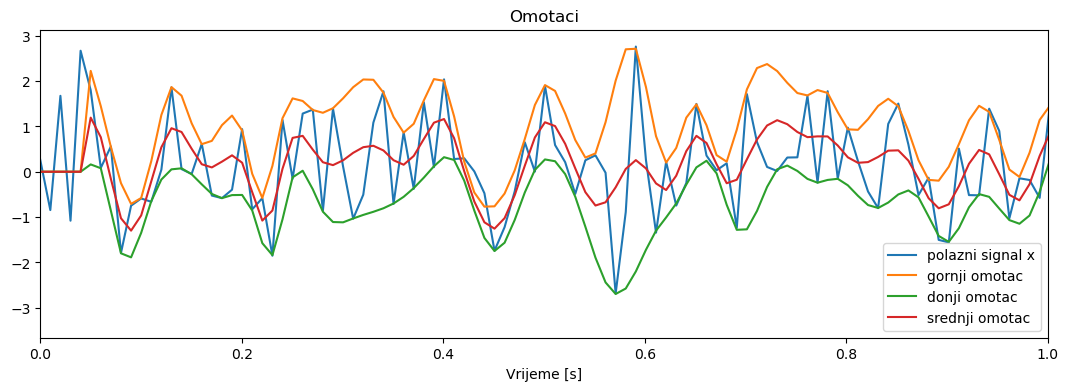

In [83]:
upperEnvelope = interp1d(upper_peaks/fs,x[upper_peaks], kind = 'cubic', fill_value = 'extrapolate')
lowerEnvelope = interp1d(lower_peaks/fs,x[lower_peaks], kind = 'cubic', fill_value = 'extrapolate')

y1 = upperEnvelope(tAxis)
y2 = lowerEnvelope(tAxis)

# Zero padding to avoid singularities at the edges of the signal
y1[0:5] = 0
y1[-5:] = 0
y2[0:5] = 0
y2[-5:] = 0
avg_envelope = (y1 + y2) / 2


plt.figure(figsize = (13,4))
plt.plot(tAxis,x, label  = 'polazni signal x')
plt.plot(tAxis,y1, label = 'gornji omotac')
plt.plot(tAxis,y2, label = 'donji omotac')
plt.plot(tAxis,avg_envelope, label = 'srednji omotac')
plt.title('Omotaci')
plt.xlim(0,1)
plt.xlabel('Vrijeme [s]')
plt.legend(loc = 'lower right')

## #3 Izracunavanje privremene IMF1 komponente

Prvi IMF se definise kao razlika originalnog (polaznog) signala i srednjeg omotaca. 
> $ tempIMF = x - avgEnvelope $  

Ako dobijeni $ tempIMF $ kandidat zadovoljava kriterijume 1. i 2. onda se on uzima kao prva $ IMF1 $ komponenta
1. Broj nula prelaza i broj lokalnih ekstrema se mogu razlikovati najvise za 1
2. Srednja vrijednost omotaca treba da bude blizu nule

Ako $ tempIMF $ kandidat ne zadovoljava gore-navedene kriterijume (1. i 2.), postupak se ponavlja ali sa $ tempIMF $ kao polaznim signalom. To ce znaciti da se traze ekstremi nad $ tempIMF $ signalom i vrsi interpolacija nad tako dobijenim ekstremima.

In [85]:
imf1 = x - avg_envelope

## #4 Azuriranje signala
Nakon izdvajanja $ IMF1 $ signal se azurira  
> $ res1  = x - IMF1 $  
> $ x = res1  + IMF1 $

Spektar signala $ res1 = x - IMF1 $  ne sadrzi najvise frekvencijske komponente jer se one sada nalaze u IMF1 signalu. Svaka IMF komponenta sadrzi najvise frekvencije signala iz prethodne iteracije. Ovo znaci da ce spektri originalnog signala $ x$ i signala dobijenog nakon prve emd iteracije $ res1  = x - IMF1 $ razlikovati upravo u oblasti najvisih frekvencija jer su sada te frekvencije u sklopu $ IMF1$

Text(0.5, 1.0, 'IMF1 u frekvencijskom domenu')

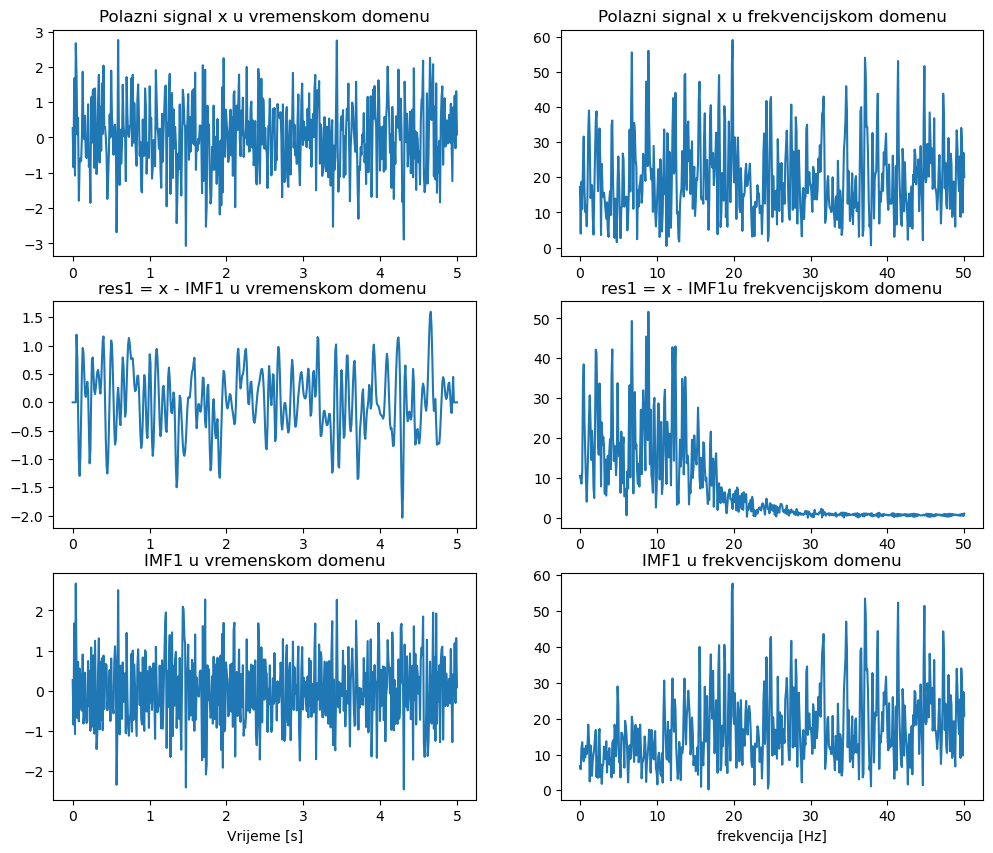

In [92]:
res1 = x - imf1

xfft1 = np.abs(fft(res1,n_fft))
xfft1 = xfft1[0:n_fft//2]

plt.figure(figsize = (12,10))

plt.subplot(3,2,1)
plt.plot(tAxis,x)
plt.title('Polazni signal x u vremenskom domenu')

plt.subplot(3,2,2)
plt.plot(fAxis,xfft)
plt.title('Polazni signal x u frekvencijskom domenu')

plt.subplot(3,2,3)
plt.plot(tAxis,res1)
plt.title('res1 = x - IMF1 u vremenskom domenu ')

plt.subplot(3,2,4)
plt.plot(fAxis,xfft1)
plt.title('res1 = x - IMF1u frekvencijskom domenu')

plt.subplot(3,2,5)
plt.plot(tAxis,imf1)
plt.xlabel('Vrijeme [s]')
plt.title('IMF1 u vremenskom domenu')

imf1fft = np.abs(fft(imf1,n_fft))
imf1fft = imf1fft[0:n_fft//2]

plt.subplot(3,2,6)
plt.plot(fAxis,imf1fft)
plt.xlabel('frekvencija [Hz]')
plt.title('IMF1 u frekvencijskom domenu')

# Druga iteracija (IMF2)

Rezidualni signal 
> $ res1  = x - IMF1 $

dobijen iz prve EMD iteracije se sada koristi kao ulazni signal za pronalazenje $ IMF2 $ komponente

Text(0.5, 1.0, 'res2 = res1 - imf2 u frekvencijskom domenu')

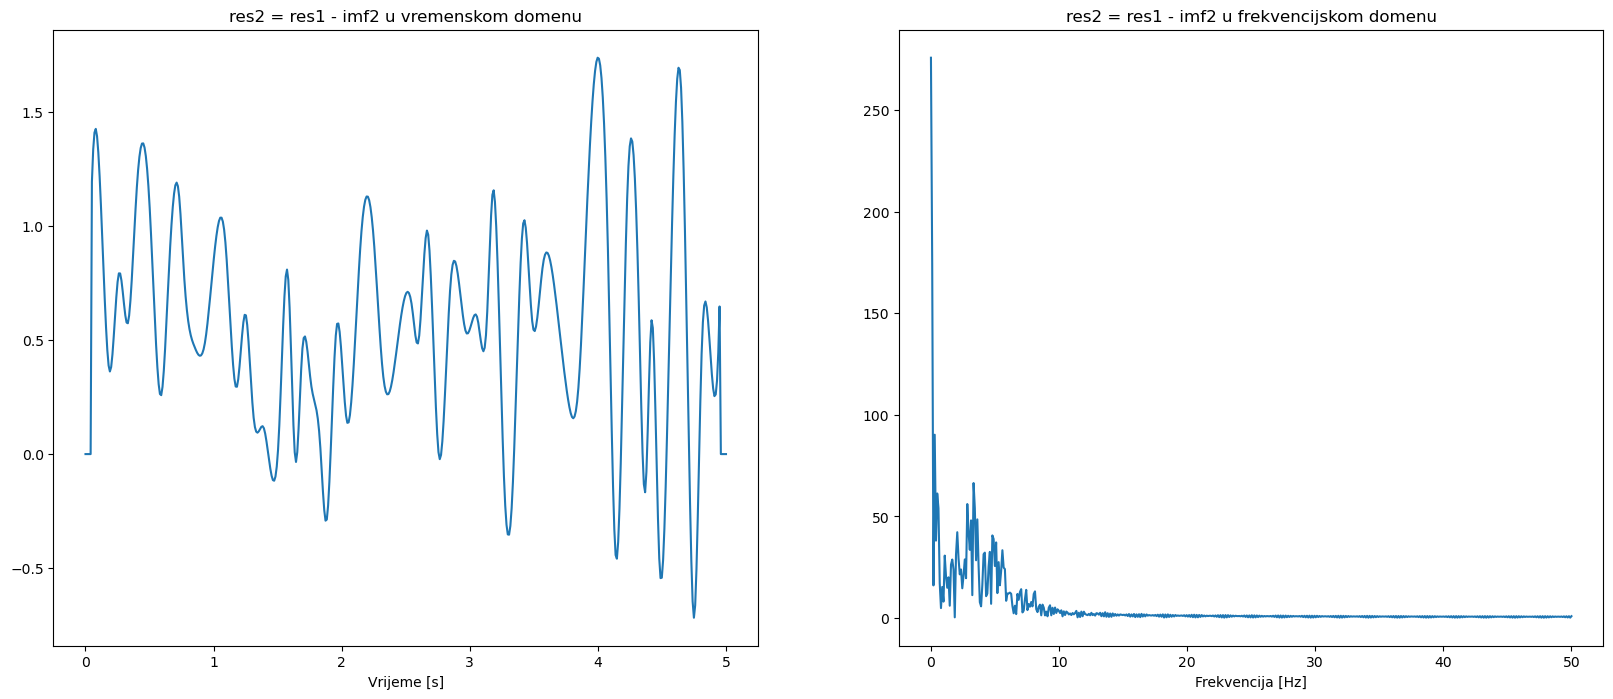

In [93]:
upper_peaks, _ = find_peaks(res1)
lower_peaks, _ = find_peaks(res1)

f1 = interp1d(upper_peaks/fs,res1[upper_peaks], kind = 'cubic', fill_value = 'extrapolate')
f2 = interp1d(lower_peaks/fs,res1[lower_peaks], kind = 'cubic', fill_value = 'extrapolate')

y1 = f1(tAxis)
y2 = f2(tAxis)
y1[0:5] = 0
y1[-5:] = 0
y2[0:5] = 0
y2[-5:] = 0

avg_envelope = (y1 + y2) / 2

imf2 = res1 - avg_envelope
res2 = res1 - imf2

xfft2 = np.abs(fft(res2,1024))
xfft2 = xfft2[0:512]

plt.figure(figsize = (20,8))
plt.subplot(1,2,1)
plt.plot(tAxis,res2)
plt.xlabel('Vrijeme [s]')
plt.title('res2 = res1 - imf2 u vremenskom domenu')
plt.subplot(1,2,2)
plt.plot(fAxis,xfft2)
plt.xlabel('Frekvencija [Hz]')
plt.title('res2 = res1 - imf2 u frekvencijskom domenu')

# Treca iteracija (IMF3)

Text(0.5, 1.0, 'res3 = res2 - imf3 u frekvencijskom domenu')

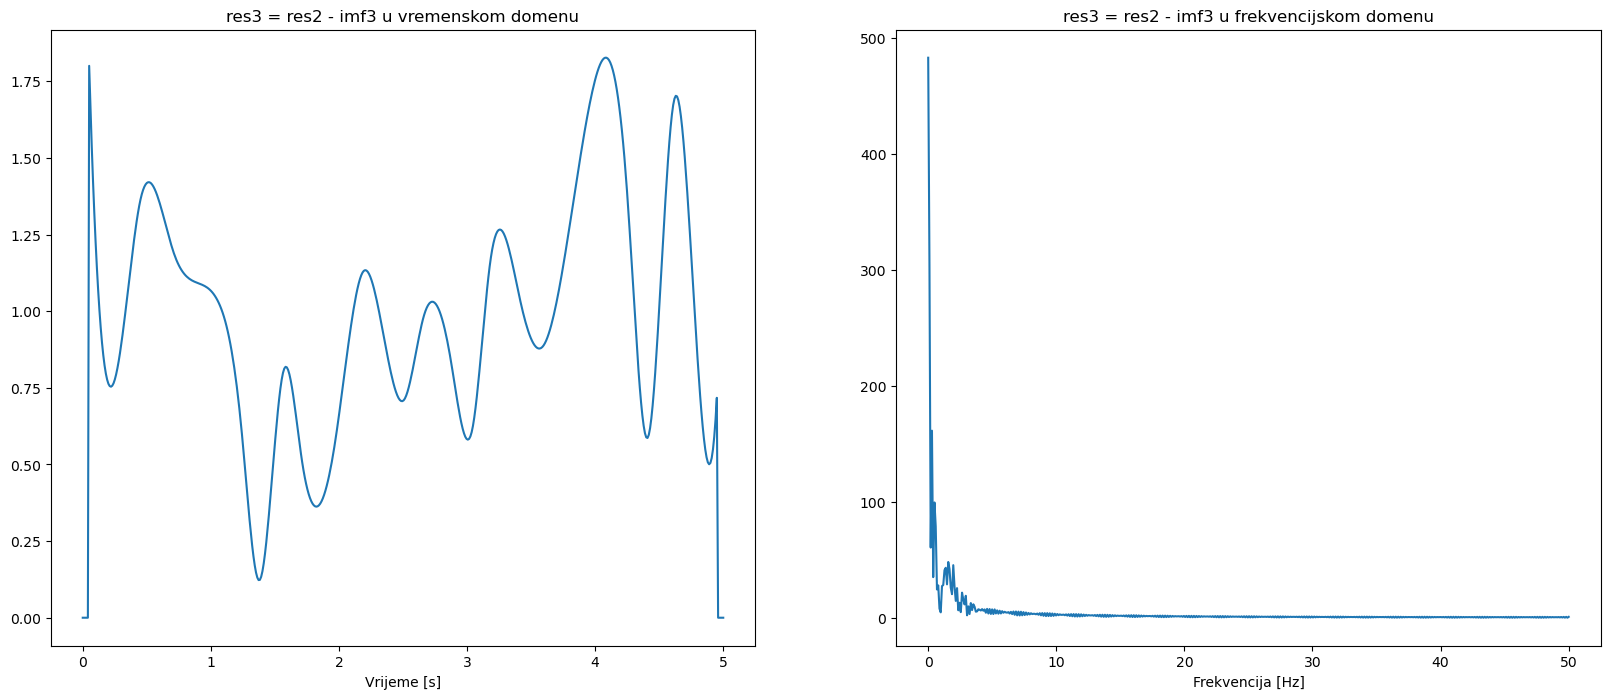

In [95]:
upper_peaks, _ = find_peaks(res2)
lower_peaks, _ = find_peaks(res2)

f1 = interp1d(upper_peaks/fs,res2[upper_peaks], kind = 'cubic', fill_value = 'extrapolate')
f2 = interp1d(lower_peaks/fs,res2[lower_peaks], kind = 'cubic', fill_value = 'extrapolate')

y1 = f1(tAxis)
y2 = f2(tAxis)
y1[0:5] = 0
y1[-5:] = 0
y2[0:5] = 0
y2[-5:] = 0

avg_envelope = (y1 + y2) / 2

imf3 = res2 - avg_envelope
res3 = res2 - imf3

xfft3 = np.abs(fft(res3,1024))
xfft3 = xfft3[0:512]

plt.figure(figsize = (20,8))
plt.subplot(1,2,1)
plt.plot(tAxis,res3)
plt.xlabel('Vrijeme [s]')
plt.title('res3 = res2 - imf3 u vremenskom domenu')
plt.subplot(1,2,2)
plt.plot(fAxis,xfft3)
plt.xlabel('Frekvencija [Hz]')
plt.title('res3 = res2 - imf3 u frekvencijskom domenu')

# Cetvrta iteracija

Text(0.5, 1.0, 'res4 = res3 - imf4 u frekvencijskom domenu')

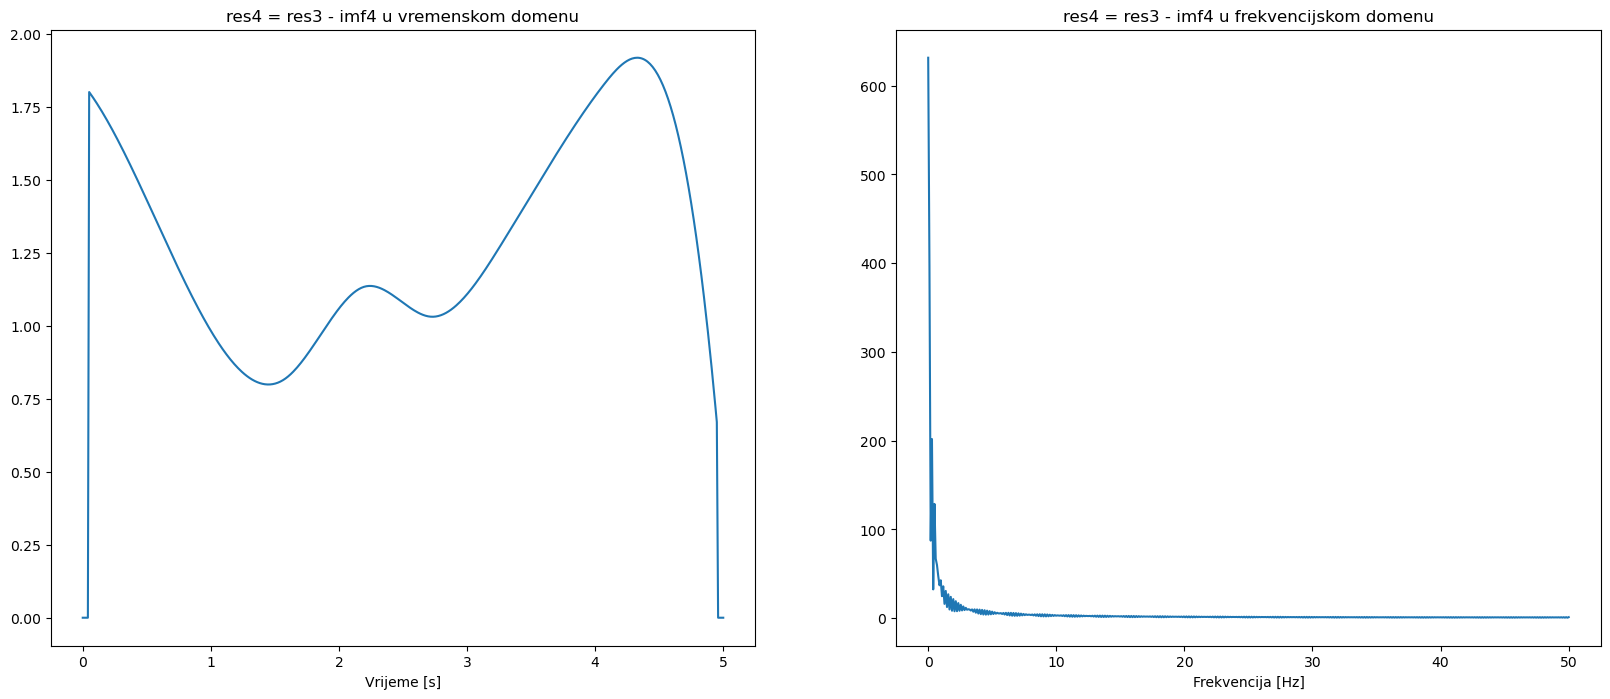

In [107]:
upper_peaks, _ = find_peaks(res3)
lower_peaks, _ = find_peaks(res3)

f1 = interp1d(upper_peaks/fs,res3[upper_peaks], kind = 'cubic', fill_value = 'extrapolate')
f2 = interp1d(lower_peaks/fs,res3[lower_peaks], kind = 'cubic', fill_value = 'extrapolate')

y1 = f1(tAxis)
y2 = f2(tAxis)
y1[0:5] = 0
y1[-5:] = 0
y2[0:5] = 0
y2[-5:] = 0

avg_envelope = (y1 + y2) / 2

imf4 = res3 - avg_envelope
res4 = res3 - imf4

xfft4 = np.abs(fft(res4,1024))
xfft4 = xfft4[0:512]

plt.figure(figsize = (20,8))
plt.subplot(1,2,1)
plt.plot(tAxis,res4)
plt.xlabel('Vrijeme [s]')
plt.title('res4 = res3 - imf4 u vremenskom domenu')
plt.subplot(1,2,2)
plt.plot(fAxis,xfft4)
plt.xlabel('Frekvencija [Hz]')
plt.title('res4 = res3 - imf4 u frekvencijskom domenu')

# Rezultat EMD algoritma

Text(0.5, 0, 'Frekvencija [Hz]')

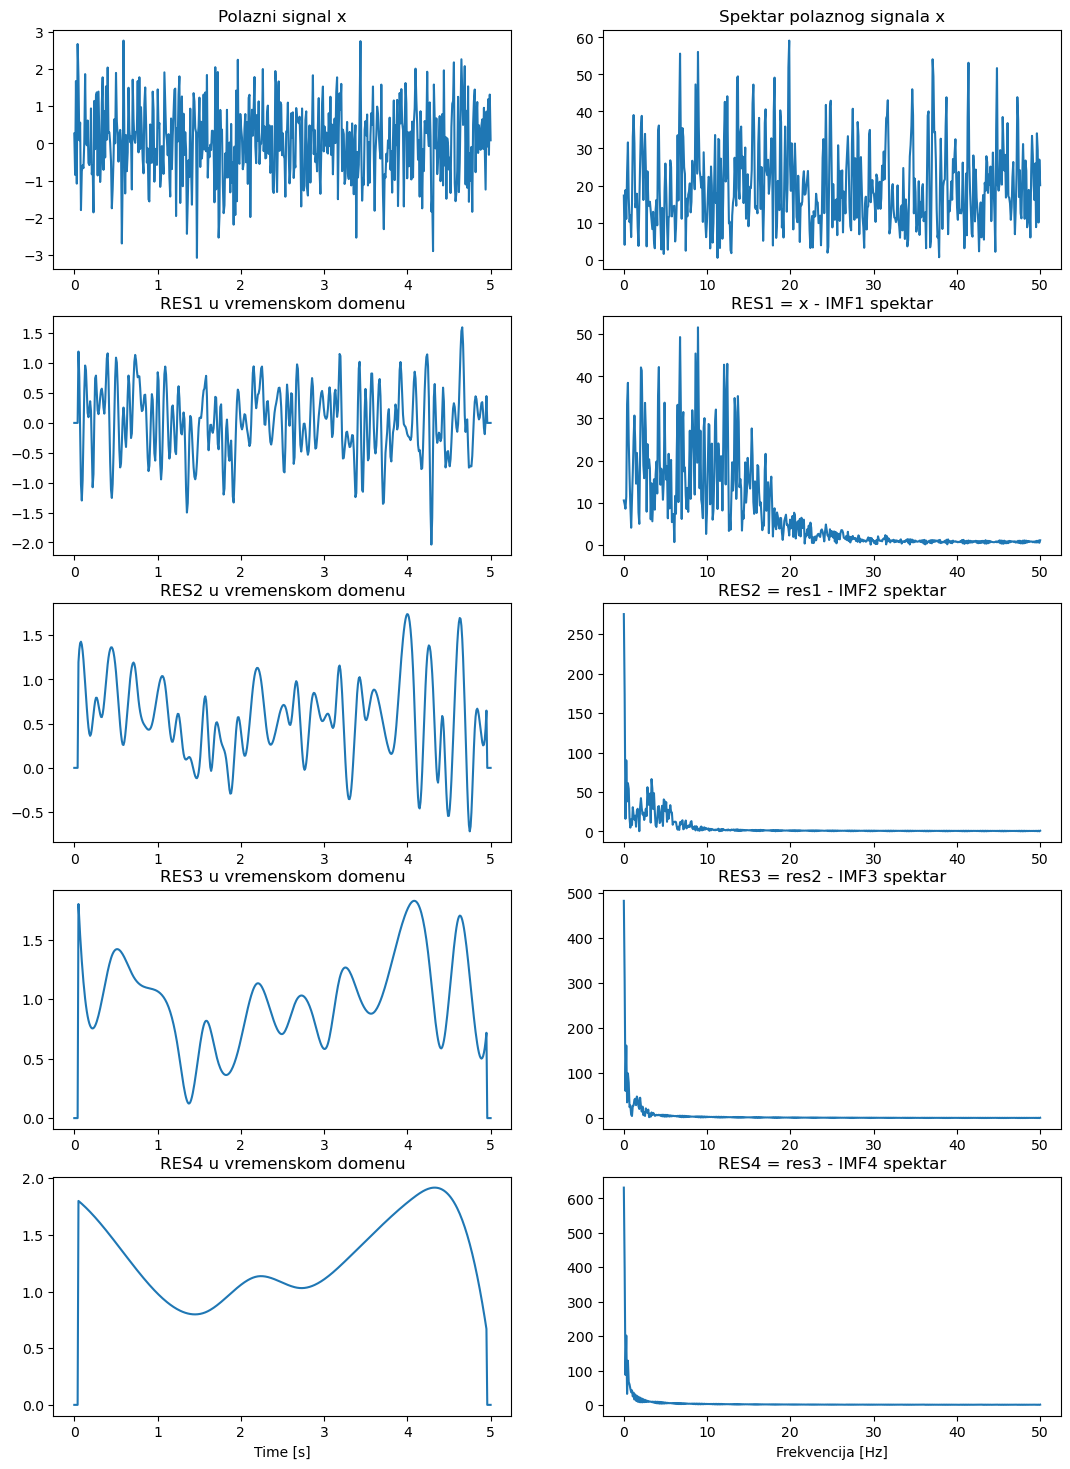

In [113]:
plt.figure(figsize = (13,18))

plt.subplot(5,2,1)
plt.plot(tAxis,x)
plt.title('Polazni signal x')

plt.subplot(5,2,2)
plt.plot(fAxis,xfft)
plt.title('Spektar polaznog signala x')

plt.subplot(5,2,3)
plt.plot(tAxis,res1)
plt.title('RES1 u vremenskom domenu')

plt.subplot(5,2,4)
plt.plot(fAxis,xfft1)
plt.title('RES1 = x - IMF1 spektar')

plt.subplot(5,2,5)
plt.plot(tAxis,res2)
plt.title('RES2 u vremenskom domenu')

plt.subplot(5,2,6)
plt.plot(fAxis,xfft2)
plt.title('RES2 = res1 - IMF2 spektar')

plt.subplot(5,2,7)
plt.plot(tAxis,res3)
plt.title('RES3 u vremenskom domenu')

plt.subplot(5,2,8)
plt.plot(fAxis,xfft3)
plt.title('RES3 = res2 - IMF3 spektar')

plt.subplot(5,2,9)
plt.plot(tAxis,res4)
plt.title('RES4 u vremenskom domenu')
plt.xlabel('Time [s]')

plt.subplot(5,2,10)
plt.plot(fAxis,xfft4)
plt.title('RES4 = res3 - IMF4 spektar')
plt.xlabel('Frekvencija [Hz]')